# PART 3 : PCA ANALYSIS 

In [5]:
from sklearn.decomposition import PCA
import numpy as np 
import nibabel as nib 
import matplotlib.pyplot as plt
from nilearn.plotting import plot_stat_map
from nilearn.image import mean_img
import os

In [6]:
output_dir_func = 'derivatives/sub_control01_preprocessed/func'
data_path = os.path.join(output_dir_func, 'concatenated_standardized_mc_smoothed.nii.gz')
img = nib.load(data_path)

affine = img.affine
data = np.asanyarray(img.dataobj)

# need a 4D image
vol_shape = data.shape[:-1]
n_vols = data.shape[-1]
data.shape

(80, 80, 50, 315)

In [7]:
# high pass filter as we do in the GLM to remove artefact (Heartbeat (~1 Hz) and breathing (~0.3 Hz) are removed)
task_music_json = 'gdrive_ds000171/ds000171/task-music_bold.json'
import json
# Open and read the JSON file
with open(task_music_json, 'r') as file:
    info = json.load(file)
# Import TR
TR = info['RepetitionTime']

# high pass filter : ------------------------ 
from scipy.signal import butter, filtfilt

cutoff = 0.01  # High-pass filter cutoff in Hz

nyquist = 1 / (2 * TR)
b, a = butter(1, cutoff / nyquist, btype='highpass')

# Apply filter to each voxel's time series
filtered_data = np.apply_along_axis(lambda x: filtfilt(b, a, x), axis=-1, arr=data)


# Spatial PCA

We want to highlight the interaction between voxels to detect specific pattern of activation among the area.

## 1. Prepare the Data

In [52]:
# voxels = features 
slice_non_background = data[:,:,:,0] != 0
# Vectorize : Taking only non-zero voxels into a vector 

# normalize
samples = data[slice_non_background]
spatial_means = np.mean(samples, axis=1)
row_means = np.outer(spatial_means, np.ones(n_vols))
X = samples - row_means

# quality check
assert np.abs(X.mean(axis=-1)).max() < 1e-5

# must be 2D image flatten x nb of volums
X.shape

(320000, 315)

## 2. Find the number of componants (90% of explained varriance)

In [53]:
# PCA 
nb_components = 80 

# YOUR CODE HERE 
pca = PCA(n_components=nb_components)
pca.fit(X.T) 

PCA(n_components=80)

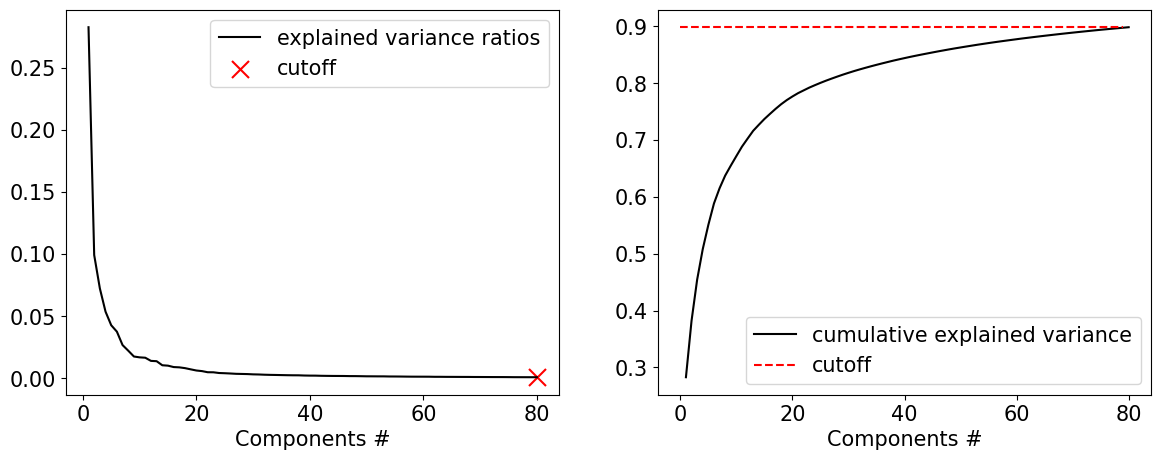

In [54]:
# Plot - choose the number of componant to use
fig, ax = plt.subplots(1, 2, figsize=(14,5))

ratios = pca.explained_variance_ratio_
cumulative_ratios = np.cumsum(pca.explained_variance_ratio_)

nb_clusters = nb_components 

ax[0].plot(np.arange(1, len(ratios)+1), ratios, label='explained variance ratios', c='k')
ax[0].scatter([nb_clusters], [ratios[nb_clusters-1]], [150], marker='x', color='r', label='cutoff')
ax[1].plot(np.arange(1, len(cumulative_ratios)+1), cumulative_ratios, label='cumulative explained variance', c='k')
ax[1].hlines(y=cumulative_ratios[nb_clusters-1], xmin=0, xmax=len(ratios)-1, linestyle='--', color='r', label='cutoff')

for k in range(2):
    ax[k].set_xlabel('Components #', size=15)
    ax[k].legend(prop={'size':15})
    ax[k].tick_params(axis='both', which='major', labelsize=15)

## 3. Get the PCA mapped

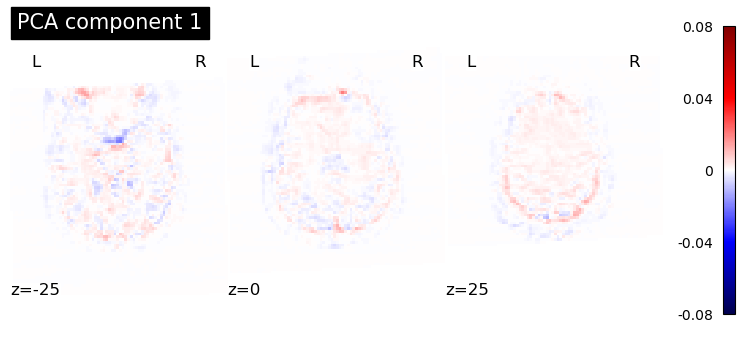

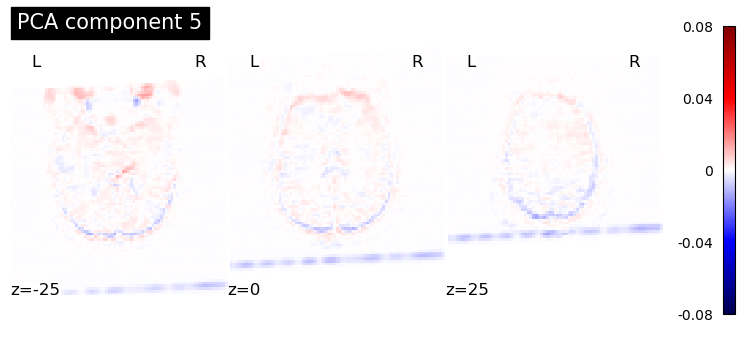

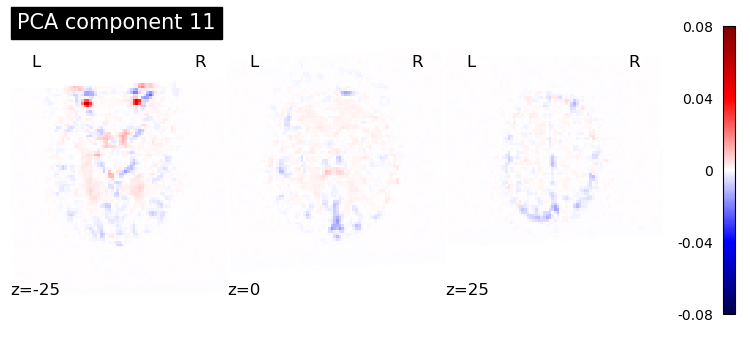

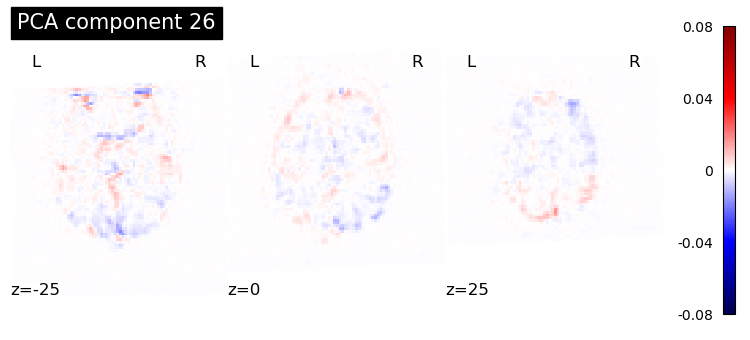

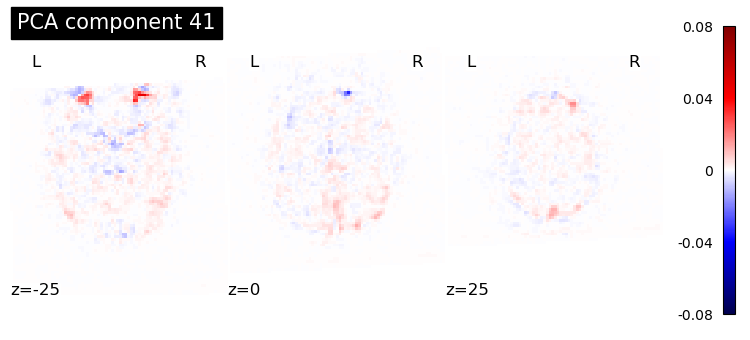

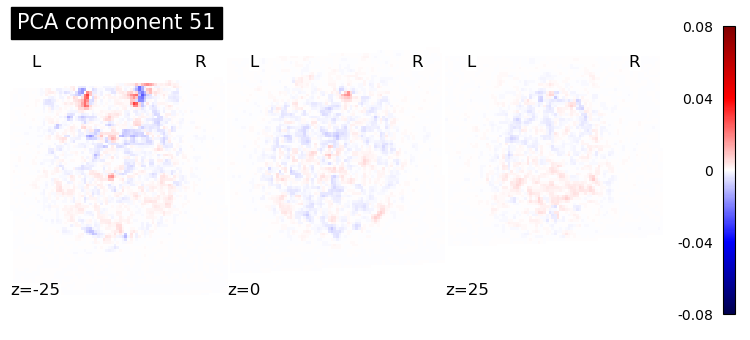

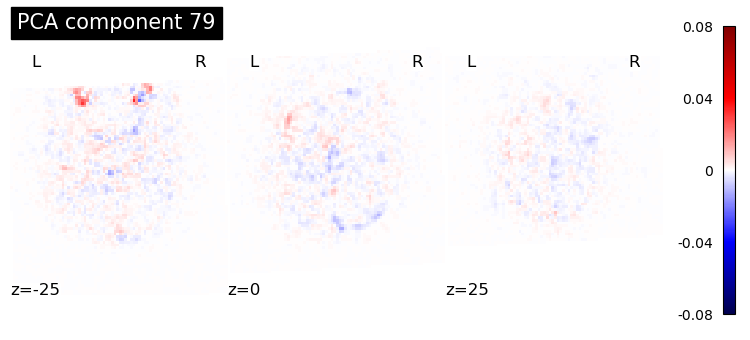

In [68]:
# Bring back to the right space

pca_clusters = []
for cluster_idx in range(nb_clusters):
    pca_component = np.zeros(vol_shape)
    pca_component[slice_non_background] = pca.components_[cluster_idx] 
    pca_clusters.append(pca_component)

mean_img_ = mean_img(img)


for comp in [0, 4, 10, 25, 40, 50, 78] : 
    pca_out = nib.Nifti1Image(pca_clusters[comp], affine)
    plot_stat_map(pca_out, bg_img=mean_img_, 
                  threshold=0,
                  vmin=-0.08, vmax=0.08,
                display_mode='z',
                cut_coords=[-25, 0, 25],
                black_bg=False,
                cmap = 'seismic',
                title=f'PCA component {comp +1}')


## 4. Save the maps 

In [60]:
folder_pca_path = 'derivatives/PCA'

if not os.path.exists(folder_pca_path):
    os.makedirs(folder_pca_path)


cluster_ids = [0,1,2,3,4,75, 76,77,78,79]
for cluster_id in cluster_ids:
    pca_out = nib.Nifti1Image(pca_clusters[cluster_id], affine)
    nib.save(pca_out, os.path.join(folder_pca_path, f'sPCA_componant{cluster_id}_thr01'))

## 5. Improve of the model 

Lot of motions componants/artifact captured by the PCA, we need to think to apply a more elaborate pipline for motion correction before using the PCA. 
we can do it using coregistration, add more specific high pass filter for artefact or more smoothing to imporve SNR, low pass for small drift or use ICA or PCA previously to capture those componants and remove them from the signal to analyse. We also notice a PCA componant capturing magnetic field inhomogeneity, we could have use the fmap to correct it during the preprocessing. 